In [28]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Download the neccessary data into the Colab Instance

In [29]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Numbers of images:  23262
Numbers of classes:  2
Tensor size:  (128, 224, 224, 3)


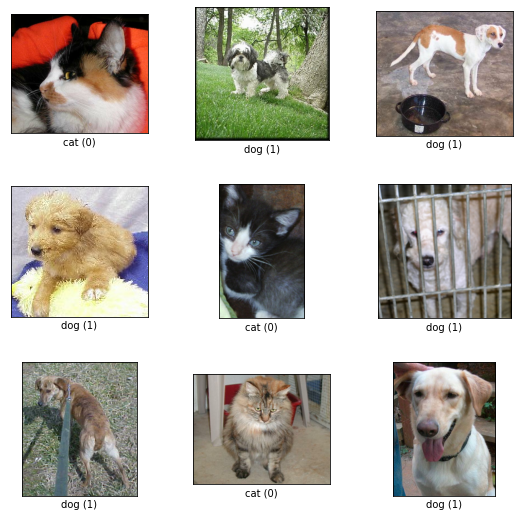

In [37]:
import tensorflow_datasets as tfds
import tensorflow as tf

BATCH_SIZE = 128
IMAGE_SIZE = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0
    return  image, label

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    data_dir='/content/dataset/',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    shuffle_files=True, 
    as_supervised=True,
)

# tf.data.experimental.cardinality(raw_train_dataset).numpy()
num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
print("Numbers of images: ", num_examples)
print("Numbers of classes: ", num_classes)

train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

for image_batch, label_batch in train_batches.take(1):
    pass

print("Tensor size: ", image_batch.shape)
fig = tfds.show_examples(raw_train, metadata)

## Define your model and optimizer

In [41]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])
print(model.summary())

from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 24, 24, 64)      

## Train your model
This may take a little while. Remember we are now building and training relatively complex computer vision models!

In [43]:
history = model.fit(
      train_batches,  
      epochs=30,
      validation_data=validation_batches)

Epoch 1/30
146/146 [==============================] - 31s 183ms/step - loss: 0.5782 - acc: 0.7022 - val_loss: 0.5439 - val_acc: 0.7322
Epoch 2/30
146/146 [==============================] - 31s 184ms/step - loss: 0.5011 - acc: 0.7558 - val_loss: 0.6129 - val_acc: 0.6741
Epoch 3/30
146/146 [==============================] - 31s 186ms/step - loss: 0.4412 - acc: 0.7947 - val_loss: 0.4312 - val_acc: 0.8074
Epoch 4/30
146/146 [==============================] - 31s 184ms/step - loss: 0.3856 - acc: 0.8254 - val_loss: 0.4077 - val_acc: 0.8130
Epoch 5/30
146/146 [==============================] - 31s 184ms/step - loss: 0.3342 - acc: 0.8527 - val_loss: 0.4253 - val_acc: 0.8194
Epoch 6/30
 57/146 [==========>...................] - ETA: 16s - loss: 0.2945 - acc: 0.8765

KeyboardInterrupt: ignored

**Explore Transfer Learning**

In [17]:
import tensorflow_hub as hub
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=False)

print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280
Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/5
582/582 [==============================] - 43s 57ms/step - loss: 0.1026 - accuracy: 0.9594 - val_loss: 0.0374 - val_accuracy: 0.9880
Epoch 2/5
140/582 [======>.......................] - ETA: 22s - loss: 0.0293 - accuracy: 0.9893

KeyboardInterrupt: ignored

In [19]:
from tqdm import tqdm
predictions = []

# This will report how many iterations per second, where each
# iteration is 100 predictions
test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    predictions.append(model.predict(img))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


# This will tell you how many of the predictions were correct
score = 0
for item in range(0,len(predictions)):
  prediction=np.argmax(predictions[item])
  label = test_labels[item]
  if prediction==label:
    score=score+1

print("Out of 100 predictions I got " + str(score) + " correct")

100%|██████████| 100/100 [00:03<00:00, 27.90it/s]

Out of 100 predictions I got 59 correct


In [20]:
#@title Utility functions for plotting
# Utilities for plotting
import matplotlib.pylab as plt
class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

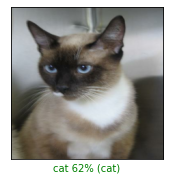

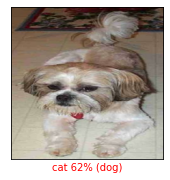

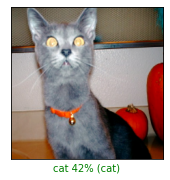

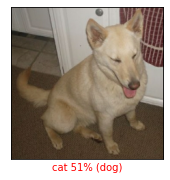

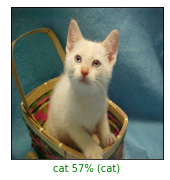

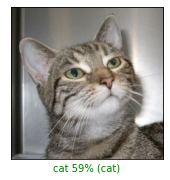

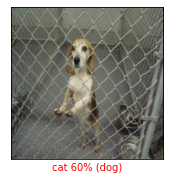

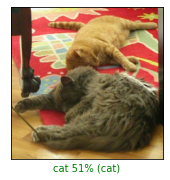

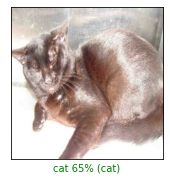

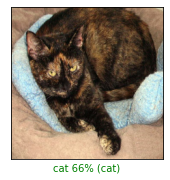

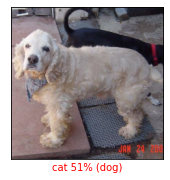

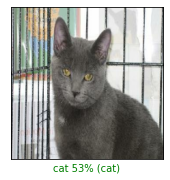

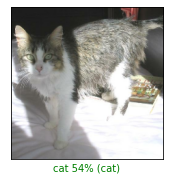

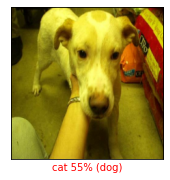

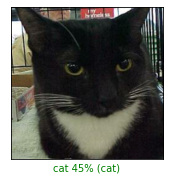

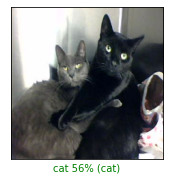

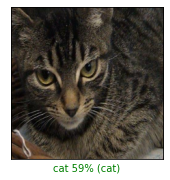

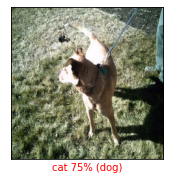

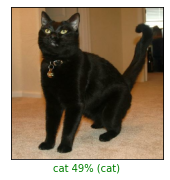

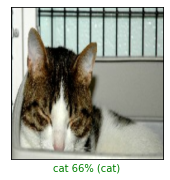

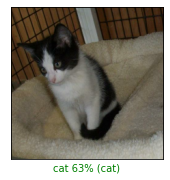

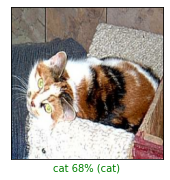

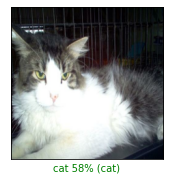

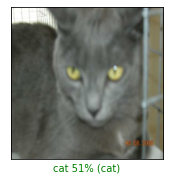

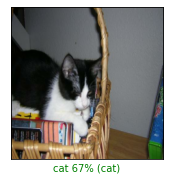

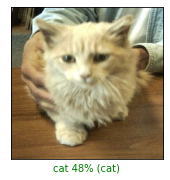

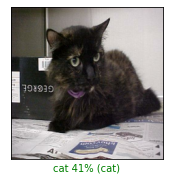

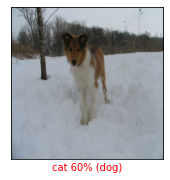

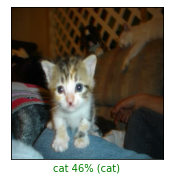

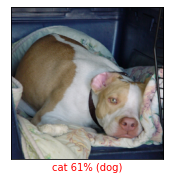

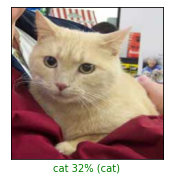

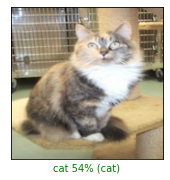

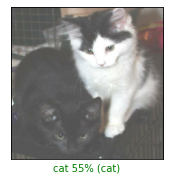

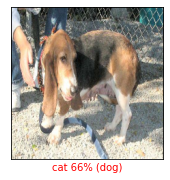

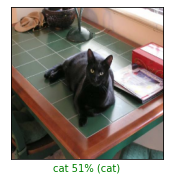

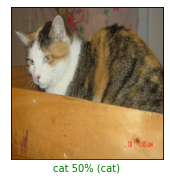

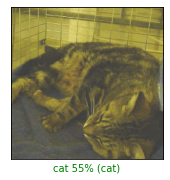

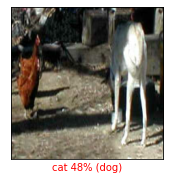

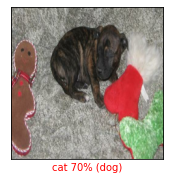

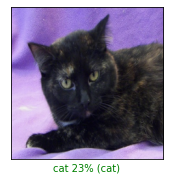

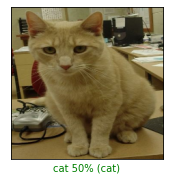

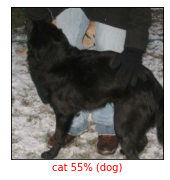

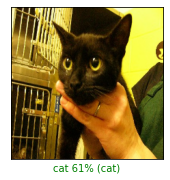

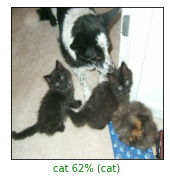

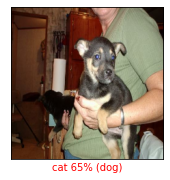

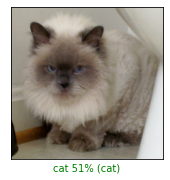

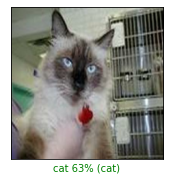

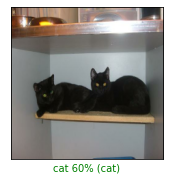

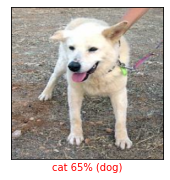

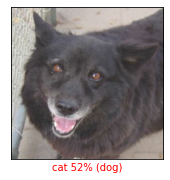

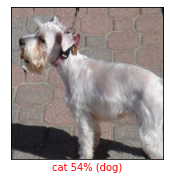

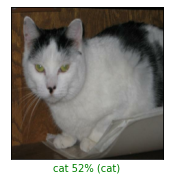

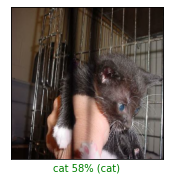

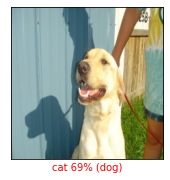

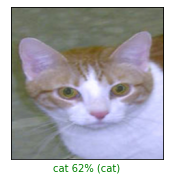

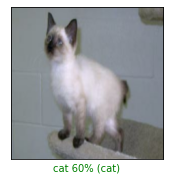

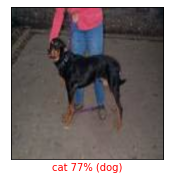

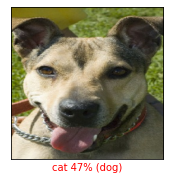

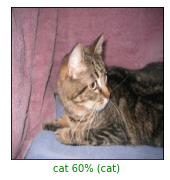

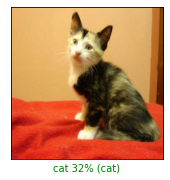

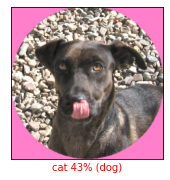

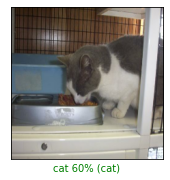

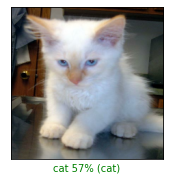

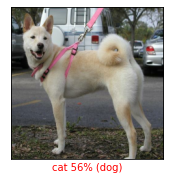

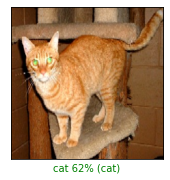

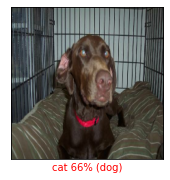

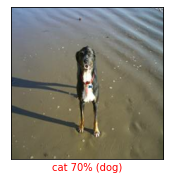

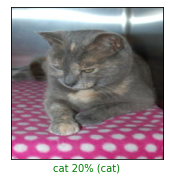

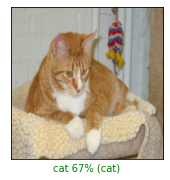

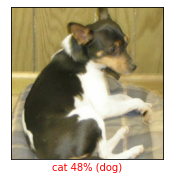

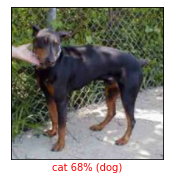

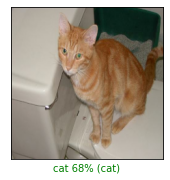

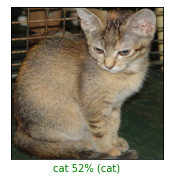

In [21]:

#@title Visualize the outputs { run: "auto" }
max_index = 73 #@param {type:"slider", min:1, max:100, step:1}
for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()

## Run your Model

Let's now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, it will then upload them, and run them through the model, giving an indication of whether the object is a dog or a cat. **Was the model correct? Try a couple more images and see if you can confuse it!**

In [12]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")
 

Saving Thinking-of-getting-a-cat.png to Thinking-of-getting-a-cat.png
[[1.]]
[1.]
Thinking-of-getting-a-cat.png is a cat


## Finally lets visualize all of the model layers!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)